In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

import warnings
warnings.filterwarnings('ignore')

import os

In [3]:
os.chdir(r"C:\Users\borja\OneDrive\Documents\C2B\Bootcamp\Módulo 8\Módulo 8\scripts\datos")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\borja\\OneDrive\\Documents\\C2B\\Bootcamp\\Módulo 8\\Módulo 8\\scripts\\datos'

In [5]:
df = pd.read_csv("data/saratogaHousing.csv")

In [6]:
df.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

In [8]:
df.isna().sum().sort_values()

precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
chimenea              0
banyos                0
habitaciones          0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

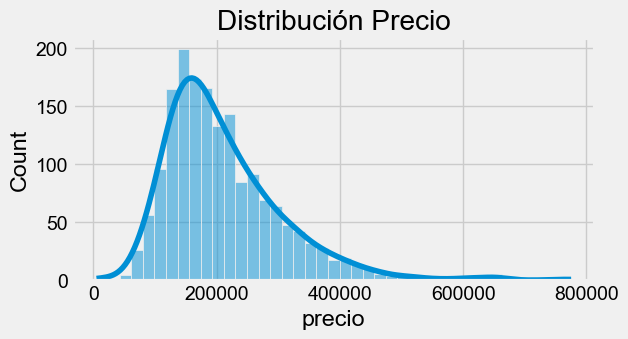

In [9]:
# Comprobamos cómo se distruyen los datos de precio de venta

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(df, x='precio', kde=True,ax=ax)
sns.set_style("white")
ax.set_title("Distribución Precio")
ax.set_xlabel('precio');

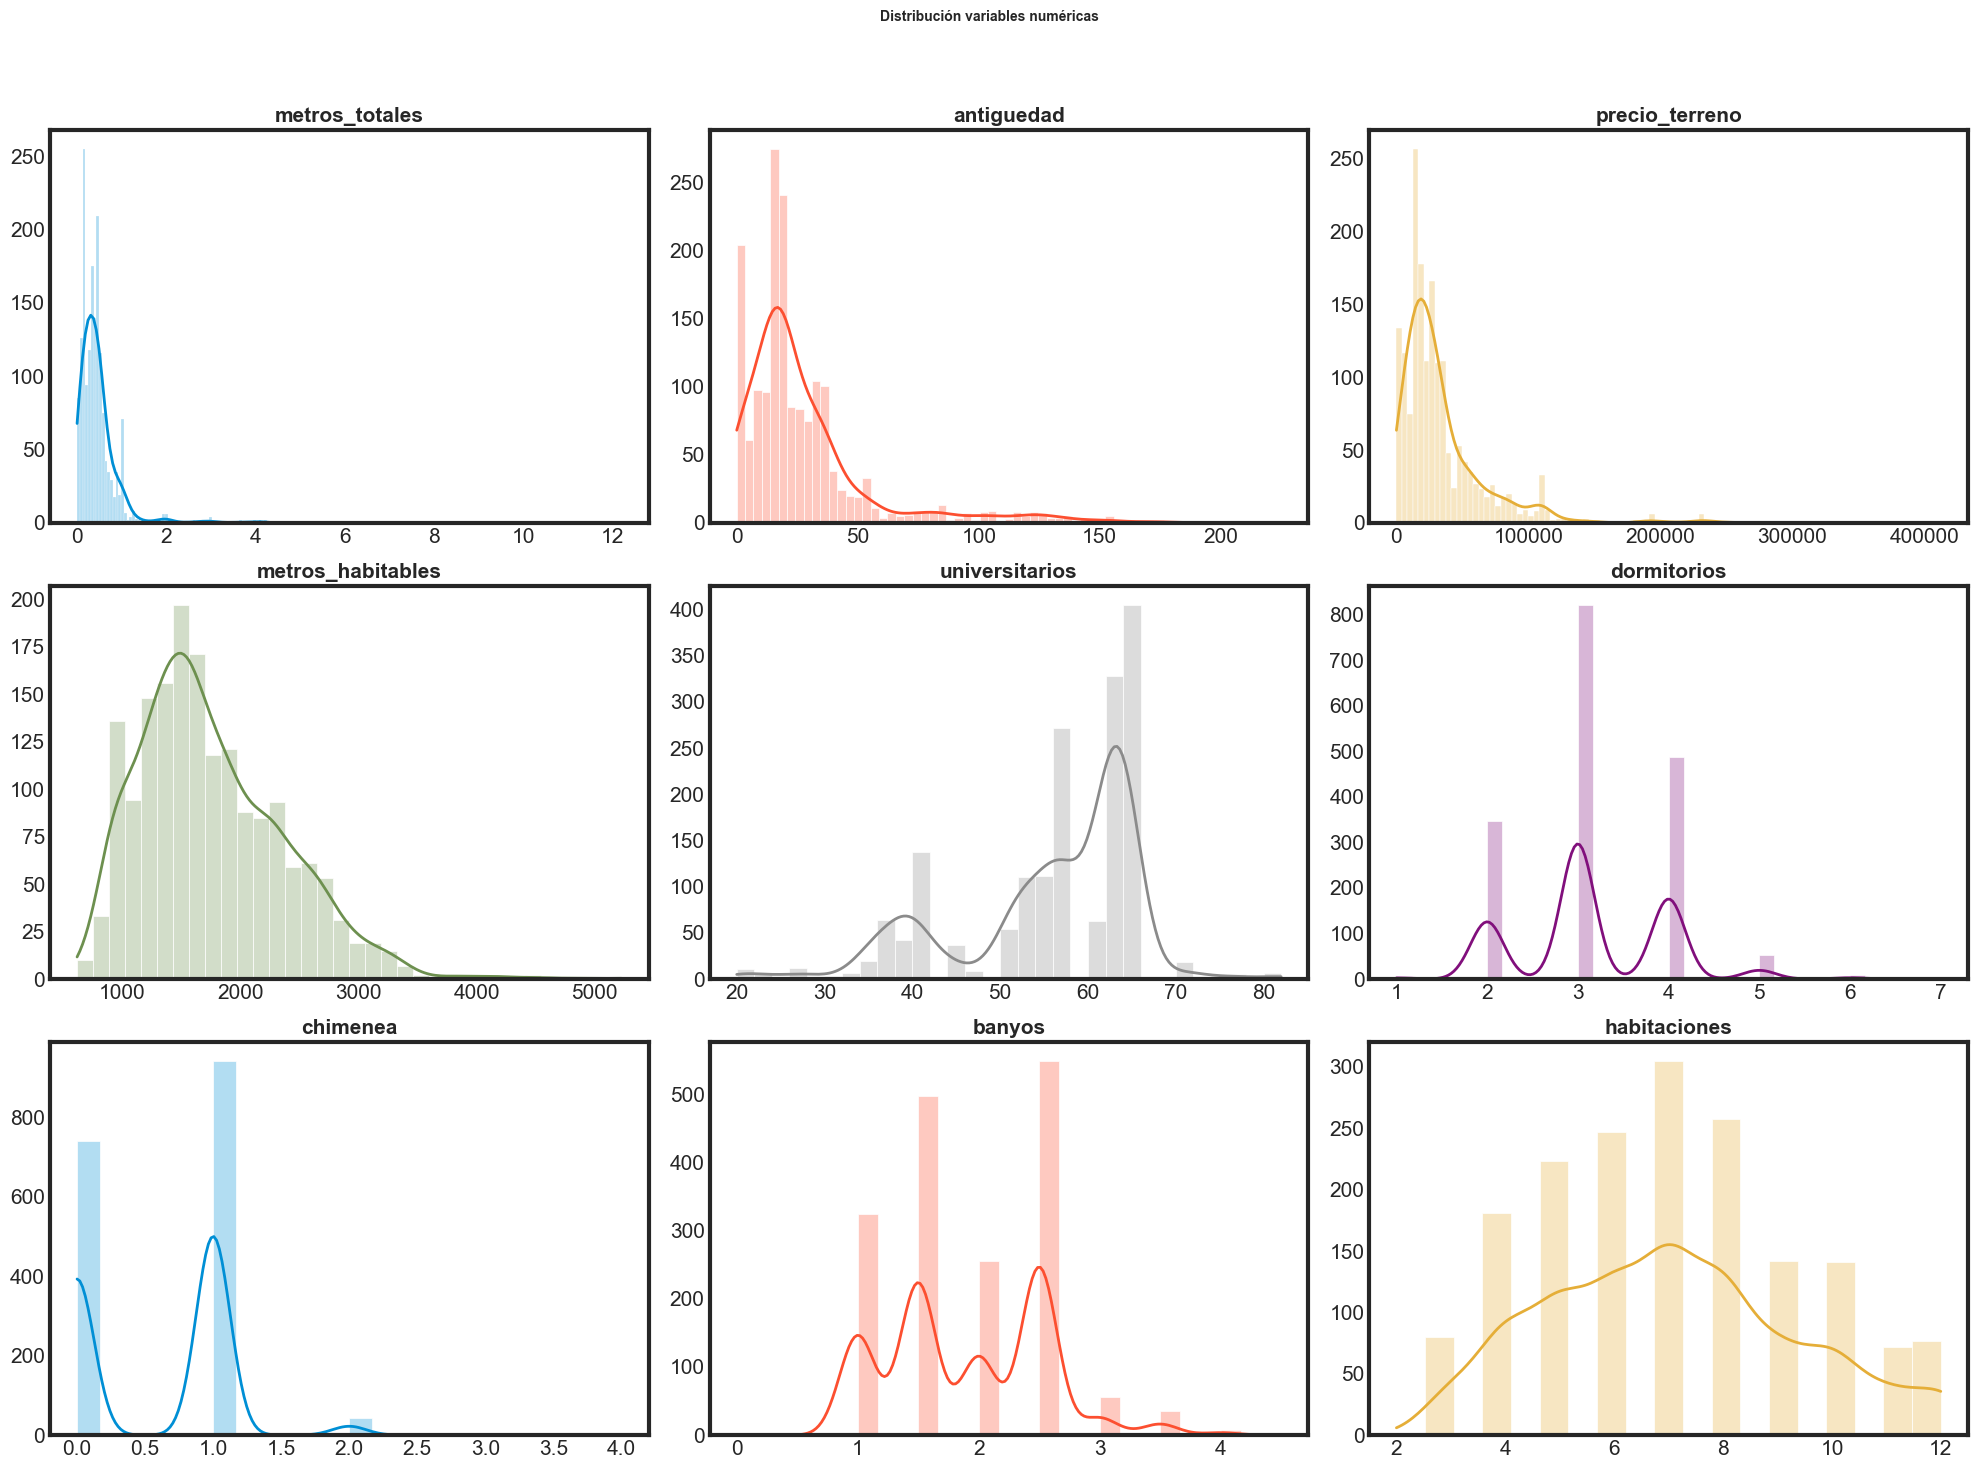

In [10]:
# Pintamos las variables numéricas

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 15)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [11]:
df.chimenea = df.chimenea.astype("str")
df.chimenea.value_counts()

chimenea
1    942
0    740
2     42
4      2
3      2
Name: count, dtype: int64

In [12]:
df.select_dtypes(include=['object']).describe()

,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728,1728
unique,5,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,942,1121,1197,1213,1713,1647,1093


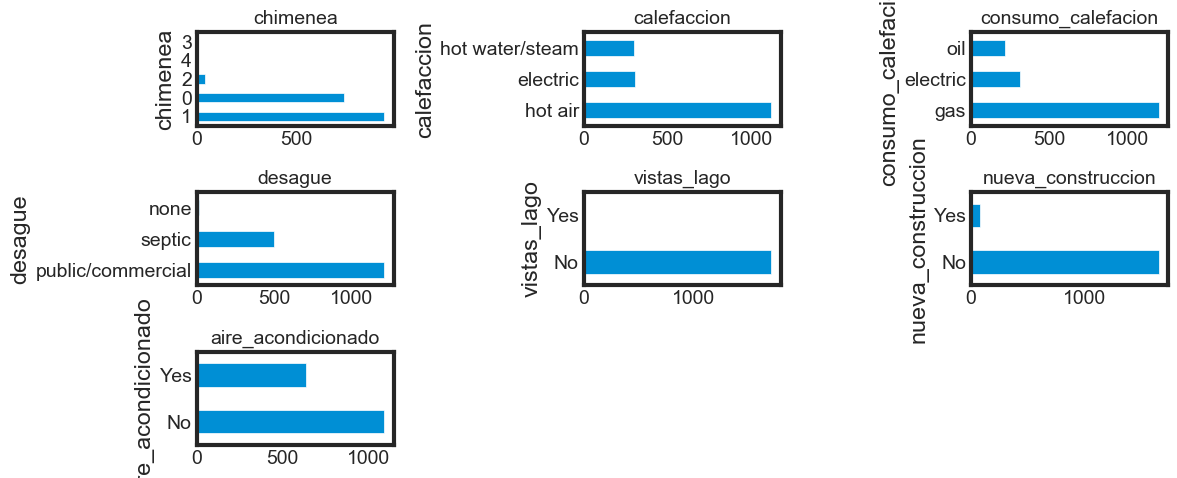

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 5))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()


In [14]:
mapeo = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

df['chimenea'] = df['chimenea'] .map(mapeo).fillna(df['chimenea'])

df.chimenea.value_counts().sort_index()


chimenea
0        740
1        942
2_mas     46
Name: count, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('precio', axis = 'columns'),
                                        df['precio'],
                                        train_size   = 0.7,
                                        random_state = 123,
                                        shuffle      = True
                                    )

In [16]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int'])
cat_cols = X_train.select_dtypes(include=['object', 'category'])

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
scaler = StandardScaler()
scaler.fit(numeric_cols)
datosNorm=scaler.transform(numeric_cols)
datosNorm = pd.DataFrame(datosNorm)

datosNorm.columns=numeric_cols.columns

datosNorm.reset_index(drop=True, inplace=True)
cat_cols = pd.get_dummies(cat_cols, drop_first=True)
cat_cols.reset_index(drop=True, inplace=True)

cat_cols



,chimenea_1,chimenea_2_mas,calefaccion_hot air,calefaccion_hot water/steam,consumo_calefacion_gas,consumo_calefacion_oil,desague_public/commercial,desague_septic,vistas_lago_Yes,nueva_construccion_Yes,aire_acondicionado_Yes
0,True,False,True,False,True,False,True,False,False,True,False
1,True,False,True,False,True,False,True,False,False,False,True
2,True,False,True,False,True,False,True,False,False,True,False
3,False,False,False,False,False,False,False,True,False,False,False
4,False,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1204,False,False,True,False,True,False,False,True,False,False,False
1205,True,False,True,False,True,False,True,False,False,False,True
1206,True,False,True,False,False,True,False,True,False,False,False
1207,True,False,True,False,True,False,False,True,False,False,False


In [17]:
datosNorm

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
0,0.067066,-0.946136,2.154927,0.559427,-1.518612,1.018523,0.875488,0.804500
1,-0.001358,-0.415613,0.143092,0.366134,0.831847,-0.205527,0.875488,-0.041274
2,-0.069782,-0.946136,-0.565260,1.837048,-0.343383,1.018523,0.875488,1.227387
3,-0.671913,0.185647,-0.353335,-0.039311,-2.008291,-0.205527,-0.644203,-0.887048
4,-0.370848,0.221015,0.418885,-0.644334,0.146296,-0.205527,-1.404048,-0.041274
...,...,...,...,...,...,...,...,...
1204,0.669196,-0.557086,-0.542035,-1.285502,0.635975,-0.205527,-1.404048,-0.887048
1205,-0.411902,-0.344877,-0.170441,-0.939774,0.831847,-1.429577,-0.644203,-1.309935
1206,-0.138206,1.069852,-0.867180,0.469852,-1.910355,-0.205527,0.115642,-0.041274
1207,-0.083467,-0.380245,-0.280758,0.003120,-1.518612,-0.205527,-0.644203,0.804500


In [18]:
datosmodelar = pd.concat([datosNorm,cat_cols], axis = 1)
datosmodelar

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones,chimenea_1,chimenea_2_mas,calefaccion_hot air,calefaccion_hot water/steam,consumo_calefacion_gas,consumo_calefacion_oil,desague_public/commercial,desague_septic,vistas_lago_Yes,nueva_construccion_Yes,aire_acondicionado_Yes
0,0.067066,-0.946136,2.154927,0.559427,-1.518612,1.018523,0.875488,0.804500,True,False,True,False,True,False,True,False,False,True,False
1,-0.001358,-0.415613,0.143092,0.366134,0.831847,-0.205527,0.875488,-0.041274,True,False,True,False,True,False,True,False,False,False,True
2,-0.069782,-0.946136,-0.565260,1.837048,-0.343383,1.018523,0.875488,1.227387,True,False,True,False,True,False,True,False,False,True,False
3,-0.671913,0.185647,-0.353335,-0.039311,-2.008291,-0.205527,-0.644203,-0.887048,False,False,False,False,False,False,False,True,False,False,False
4,-0.370848,0.221015,0.418885,-0.644334,0.146296,-0.205527,-1.404048,-0.041274,False,False,True,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,0.669196,-0.557086,-0.542035,-1.285502,0.635975,-0.205527,-1.404048,-0.887048,False,False,True,False,True,False,False,True,False,False,False
1205,-0.411902,-0.344877,-0.170441,-0.939774,0.831847,-1.429577,-0.644203,-1.309935,True,False,True,False,True,False,True,False,False,False,True
1206,-0.138206,1.069852,-0.867180,0.469852,-1.910355,-0.205527,0.115642,-0.041274,True,False,True,False,False,True,False,True,False,False,False
1207,-0.083467,-0.380245,-0.280758,0.003120,-1.518612,-0.205527,-0.644203,0.804500,True,False,True,False,True,False,False,True,False,False,False


In [20]:
# Definiremos el modelo como una secuencia de capas.
# Usaremos el modelo secuencial de manera que podamos ir añadiendo capas hasta estar contentos con la arquitectura desarrollada.
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

model = Sequential()

# Partimos de un sistema con 8 variables por lo que nuestra primera capa acomodará dichas variables
# En la primera capa oculta usaremos 12 neuronas y una función de activación ReLU
# En la segunda capa oculta usaremos 8 neuronas y una función de activación ReLU
# Finalmente en la de salida una neurona y función de activación sigmoide
model.add(Dense(190, input_dim=datosmodelar.shape[1], activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(1))

# Nota: Fíjate que el total de neuronas de entrada, lo definimos en la primera capa con input_dim

In [21]:
optimizer = optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

In [22]:

model.fit(datosmodelar, y_train, epochs=150, batch_size=10)


Epoch 1/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 54542487552.0000 - mae: 212411.5469 - mse: 54542487552.0000
Epoch 2/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54254551040.0000 - mae: 212754.8750 - mse: 54254551040.0000
Epoch 3/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58667470848.0000 - mae: 217341.4688 - mse: 58667466752.0000
Epoch 4/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49874599936.0000 - mae: 203129.0156 - mse: 49874599936.0000
Epoch 5/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39303413760.0000 - mae: 180984.7188 - mse: 39303413760.0000
Epoch 6/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33103976448.0000 - mae: 164826.8438 - mse: 33103978496.0000
Epoch 7/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21825175552.0000 - mae: 132059.7500 - mse: 21825175552.0000
Epoch 8/150
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15193593856.0000 - mae: 103494.6562 - mse: 15193594880.0000
Epoch 9/150
121/121 ━━━━━━━━━━━━

In [23]:
model.evaluate(datosmodelar,y_train)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 2968514560.0000 - mae: 39996.0586 - mse: 2968514560.0000


[3151872512.0, 41187.52734375, 3151872512.0]

In [24]:
Pred_Train = model.predict(datosmodelar)

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [25]:
from sklearn.metrics import r2_score
r2_score(y_train,Pred_Train)

0.666344940662384

In [26]:
# Repetimos el procesado para test

numeric_cols = X_test.select_dtypes(include=['float64', 'int'])
cat_cols = X_test.select_dtypes(include=['object', 'category'])

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
scaler = StandardScaler()
scaler.fit(numeric_cols)
datosNorm=scaler.transform(numeric_cols)
datosNorm = pd.DataFrame(datosNorm)

datosNorm.columns=numeric_cols.columns

datosNorm.reset_index(drop=True, inplace=True)
cat_cols = pd.get_dummies(cat_cols, drop_first=True)
cat_cols.reset_index(drop=True, inplace=True)

cat_cols

,chimenea_1,chimenea_2_mas,calefaccion_hot air,calefaccion_hot water/steam,consumo_calefacion_gas,consumo_calefacion_oil,desague_public/commercial,desague_septic,vistas_lago_Yes,nueva_construccion_Yes,aire_acondicionado_Yes
0,False,False,True,False,True,False,False,True,False,False,False
1,False,False,True,False,False,True,False,True,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,True,True,False,True,False,False,False,False
4,False,False,False,True,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
514,True,False,True,False,True,False,True,False,False,False,True
515,True,False,True,False,True,False,False,True,False,False,True
516,False,False,True,False,False,True,False,True,False,False,False
517,True,False,True,False,True,False,True,False,False,False,True


In [27]:
datostesteo = pd.concat([datosNorm,cat_cols], axis = 1)
datostesteo

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones,chimenea_1,chimenea_2_mas,calefaccion_hot air,calefaccion_hot water/steam,consumo_calefacion_gas,consumo_calefacion_oil,desague_public/commercial,desague_septic,vistas_lago_Yes,nueva_construccion_Yes,aire_acondicionado_Yes
0,0.186490,0.204908,-0.823666,-1.120860,-1.858988,-0.151005,-1.289625,-0.415754,False,False,True,False,True,False,False,True,False,False,False
1,-0.186834,0.301412,-0.845710,-1.287606,-1.858988,-0.151005,-1.289625,-0.871940,False,False,True,False,False,True,False,True,False,False,False
2,-0.089445,-0.309779,-0.607361,-0.710941,0.781756,-0.151005,-0.526438,-0.415754,False,False,False,False,False,False,True,False,False,False,False
3,-0.446537,2.360161,1.948339,0.543131,0.121570,3.522657,-1.289625,1.865178,False,False,False,True,True,False,True,False,False,False,False
4,-0.592621,2.907017,1.452354,0.947838,0.593132,1.073549,0.236750,0.496619,False,False,False,True,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,-0.706241,-0.502787,0.047063,0.525761,0.121570,-0.151005,0.999937,0.496619,True,False,True,False,True,False,True,False,False,False,True
515,-0.625084,-0.599291,-0.085199,0.588291,-0.349991,1.073549,0.999937,0.040433,True,False,True,False,True,False,False,True,False,False,True
516,0.851980,-0.116772,-0.716203,-0.994063,-1.670363,-1.375559,-1.289625,0.040433,False,False,True,False,False,True,False,True,False,False,False
517,0.024175,-0.374115,0.785530,0.890519,0.781756,1.073549,0.999937,1.408991,True,False,True,False,True,False,True,False,False,False,True


In [26]:
Pred_Test = model.predict(datostesteo)

17/17 [==============================] - 0s 1ms/step


In [27]:
r2_score(y_test,Pred_Test)

0.47899181497875687